In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os
from sklearn.preprocessing import MinMaxScaler 
import seaborn as sns
import pickle
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Introduction

The purpose of this notebook is to analyze the performance of the teams on the premier league using a bayesian model. The final output is a prediction of the number of points each team should have at the end of the season.


In [0]:
data_dir =  'drive/My Drive/ISyE 6416 - Project/data/'
df = pd.read_csv(data_dir+'train.csv')

In [0]:
## Some data cleaning
df.Date = df.Date.apply(lambda x: pd.to_datetime(x, format="%d/%m/%y") if len(x) == 8 else pd.to_datetime(x, format="%d/%m/%y") if x['/'] == '/'else pd.to_datetime(x, format="%d/%m/%Y") )
df = df.sort_values(by='Date')

In [0]:
team = 'Arsenal'
lb = 5 # How many mathces should I look back

cols = ['FT{}G','FT{}G', 'HTR', '{}S']

running = [[] for _ in cols]

total = [[] for _ in cols]

wins = []

for i, row in df[(df.HomeTeam == team) | (df.AwayTeam == team)].iterrows():
  t, r = ('H', 'A') if row['HomeTeam'] == team else ('A', 'H')
  strs = [t,r,t,t]
  for j, c in enumerate(cols):
    res = row[c.format(strs[j])]
    res = 1 if res == t else 0.5 if res == 'D' else 0 if res==r else res
    running[j].append(res)
    
    if len(running[j]) >lb:
      running[j] = running[j][1:(lb+1)]
    total[j].append(np.mean(running[j]))
  wins.append(running[2][-1])

Arsenal = pd.DataFrame({'Date': df[(df.HomeTeam == team) | (df.AwayTeam == team)].Date,
              'AvgGoalsFavor': total[0],
              'AvgGoalsAgainst': total[1],
              'AvgWins': total[2],
              'AvgShots': total[3],
              'Win' : wins})

Arsenal.Win = Arsenal.Win.apply(lambda x: 'W' if x==1 else 'D' if x==0.5 else 'L')

In [0]:
Arsenal

,Date,AvgGoalsFavor,AvgGoalsAgainst,AvgWins,AvgShots,Win
1520,2014-08-16,2.000000,1.000000,0.500000,14.0,D
1533,2014-08-23,2.000000,1.500000,0.250000,13.5,L
1548,2014-08-31,1.666667,1.333333,0.333333,17.0,D
1550,2014-09-13,1.750000,1.500000,0.250000,16.5,L
1560,2014-09-20,2.000000,1.200000,0.400000,15.0,W
...,...,...,...,...,...,...
1102,2019-04-21,1.400000,0.800000,0.600000,11.8,L
1109,2019-04-24,1.200000,1.400000,0.400000,11.2,L
1118,2019-04-28,0.800000,2.000000,0.300000,11.0,D
1126,2019-05-05,1.000000,2.000000,0.500000,13.6,W


In [0]:
clust_cols = ~Arsenal.columns.isin(['Date', 'Win'])
min_max_scaler  = MinMaxScaler()
train = min_max_scaler.fit_transform(Arsenal.loc[:, clust_cols])
kmeans = KMeans(n_clusters=3).fit(train)
Arsenal['Cluster'] = kmeans.predict(train)

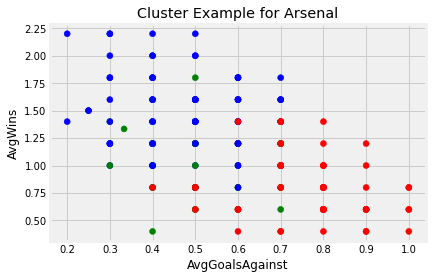

In [0]:
plt.scatter(x=Arsenal.AvgWins, y= Arsenal.AvgGoalsAgainst, color = Arsenal.Cluster.apply(lambda x: 'r' if x==2 else 'b' if x==1 else 'g'))
plt.xlabel('AvgGoalsAgainst')
plt.ylabel('AvgWins')

plt.title('Cluster Example for Arsenal')
plt.savefig('Arsenal Clusters.png', format='png')
plt.show()


In [0]:
up, down = kmeans.cluster_centers_[:,0].argmax(), kmeans.cluster_centers_[:,0].argmin()
medium = [i for i,x in enumerate(kmeans.cluster_centers_[:,0]) if i not in [up, down]][0]
Arsenal.Cluster = Arsenal.Cluster.apply(lambda x: 'DOWN' if x==down else 'MEDIUM' if x==medium else 'UP')

In [0]:
Arsenal['Transition'] ='NN'
Arsenal['PrevCluster'] = 'NN'

old = 'UP'
for i,row in Arsenal.iterrows():
  now = row['Cluster']
  Arsenal.loc[i, 'Transition'] = old[0]+now[0]
  Arsenal.loc[i, 'PrevCluster'] = old
  old= now


In [0]:
Arsenal['ClusterTotal'] = Arsenal.PrevCluster.map(Arsenal.groupby('PrevCluster')['Transition'].count())

Arsenal.groupby('Transition')['Cluster'].count()/Arsenal.groupby('Transition')['ClusterTotal'].mean()

Transition
DD    0.692308
DM    0.230769
DU    0.076923
MD    0.071429
MM    0.809524
MU    0.119048
UD    0.089552
UM    0.119403
UU    0.791045
dtype: float64

In [0]:

         #1+wins   #1+draw   #1+losses
alpha = [1+2,         1+1,        1]
np.random.dirichlet(alpha, size=100000).mean(axis=0)

array([0.49990457, 0.33308804, 0.16700739])

In [0]:
## Adding the state addition

        #1+wins+state           #1+draw   #1+losses
alpha = [1+1+0.5,                1,        1]
np.random.dirichlet(alpha, size=100000).mean(axis=0)

array([0.55571398, 0.22189905, 0.22238697])

In [0]:
def transition_probs(team):
  lb = 5 # How many mathces should I look back

  cols = ['FT{}G','FT{}G', 'HTR', '{}S']

  running = [[] for _ in cols]

  total = [[] for _ in cols]

  wins = []

  for i, row in df[(df.HomeTeam == team) | (df.AwayTeam == team)].iterrows():
    t, r = ('H', 'A') if row['HomeTeam'] == team else ('A', 'H')
    strs = [t,r,t,t]
    for j, c in enumerate(cols):
      res = row[c.format(strs[j])]
      res = 1 if res == t else 0.5 if res == 'D' else 0 if res==r else res
      running[j].append(res)
      
      if len(running[j]) >lb:
        running[j] = running[j][1:(lb+1)]
      total[j].append(np.mean(running[j]))
    wins.append(running[2][-1])

  Arsenal = pd.DataFrame({'Date': df[(df.HomeTeam == team) | (df.AwayTeam == team)].Date,
                'AvgGoalsFavor': total[0],
                'AvgGoalsAgainst': total[1],
                'AvgWins': total[2],
                'AvgShots': total[3],
                'Win' : wins})

  Arsenal.Win = Arsenal.Win.apply(lambda x: 'W' if x==1 else 'D' if x==0.5 else 'L')
  clust_cols = ~Arsenal.columns.isin(['Date', 'Win'])
  min_max_scaler  = MinMaxScaler()
  train = min_max_scaler.fit_transform(Arsenal.loc[:, clust_cols])
  kmeans = KMeans(n_clusters=3).fit(train)
  Arsenal['Cluster'] = kmeans.predict(train)
  up, down = kmeans.cluster_centers_[:,0].argmax(), kmeans.cluster_centers_[:,0].argmin()
  medium = [i for i,x in enumerate(kmeans.cluster_centers_[:,0]) if i not in [up, down]][0]
  Arsenal.Cluster = Arsenal.Cluster.apply(lambda x: 'DOWN' if x==down else 'MEDIUM' if x==medium else 'UP')
  Arsenal['Transition'] ='NN'
  Arsenal['PrevCluster'] = 'NN'

  old = 'UP'
  for i,row in Arsenal.iterrows():
    now = row['Cluster']
    Arsenal.loc[i, 'Transition'] = old[0]+now[0]
    Arsenal.loc[i, 'PrevCluster'] = old
    old= now
  Arsenal['ClusterTotal'] = Arsenal.PrevCluster.map(Arsenal.groupby('PrevCluster')['Transition'].count())
  states=min_max_scaler.inverse_transform(kmeans.cluster_centers_)[[up, medium, down], 0]

  return (Arsenal.groupby('Transition')['Cluster'].count()/Arsenal.groupby('Transition')['ClusterTotal'].mean() ,
    {'U': states[0], 'M': states[1], 'D': states[2]})


def read_team_data(team):
  df = pd.read_excel(data_dir + 'Head to head.xlsx', sheet_name=team).fillna(0)
  df['Win'] = df['Home win'].astype(np.int32) + df['Away win'].astype(np.int32)
  df['Loss'] = df['Home loss'].astype(np.int32) + df['Away loss'].astype(np.int32)
  df['Draw'] = df['Home draw'].astype(np.int32) + df['Away draw'].astype(np.int32)
  return df



def win_prob(home_team, away_team, home_state, away_state):
  if home_team not in teams or away_team not in teams:
    return np.random.dirichlet([0.5+home_state,0.5,0.5+away_state])
    #return np.random.dirichlet([0.5+home_state,0.5,0.5+away_state], size=10000).mean(axis=0) 
  params = team_data[home_team].loc[team_data[home_team].Team == away_team, ['Win', 'Draw', 'Loss']].values[0].astype(np.float64)
  params[0] += home_state
  params[2] += away_state
  params +=0.5
  return np.random.dirichlet(params)
  #return np.random.dirichlet(params, size=10000).mean(axis=0)

def next_state(transition, s):
  if transition ==0:
    return s
  t = transition[0]
  idx = t.index.str.startswith(s)
  states = t[idx].index.str.slice(1)
  return np.random.choice(states,p = t[idx] )


In [0]:
teams = ['Arsenal','Bournemouth','Burnley','Chelsea','Crystal Palace','Everton', 'Leicester',
 'Liverpool','Man City','Man United','Newcastle','Southampton','Tottenham','West Ham']

states = ['U', 'M', 'D']
transitions = {team: transition_probs(team) for team in teams}
team_data = {team: read_team_data(team) for team in teams}

results = pd.read_csv(data_dir+'epl-2019-2020.csv')

results.loc[results['Home Team'] == 'Man Utd', 'Home Team'] = 'Man United'
results.loc[results['Away Team'] == 'Man Utd', 'Away Team'] = 'Man United'

results.loc[results['Home Team'] == 'Spurs', 'Home Team'] = 'Tottenham'
results.loc[results['Away Team'] == 'Spurs', 'Away Team'] = 'Tottenham'



In [0]:
results['WinProb'] = 0
results['DrawProb'] = 0
results['LossProb'] = 0
table = {team: 0 for team in results['Away Team'].unique()}
team_state = {team: np.random.choice(states) for team in results['Away Team'].unique()}

for i, match in results.iterrows():
  home_team = match['Home Team']
  away_team = match['Away Team']
  home_state = transitions.get(home_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[home_team]]
  away_state = transitions.get(away_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[away_team]]
  prob = win_prob(home_team, away_team, home_state, away_state)
  results.loc[i, ['WinProb', 'DrawProb', 'LossProb']] = prob
  team_state[home_team] = next_state(transitions.get(home_team, 0), team_state[home_team])
  team_state[away_team] = next_state(transitions.get(away_team, 0), team_state[away_team])
  if np.argmax(prob) == 0:
    table[home_team] += 3
  elif np.argmin(prob) == 2:
    table[away_team] += 3
  else:
    table[home_team] += 1
    table[away_team] += 1




In [0]:
keys = list(team_state.keys())
tables = pd.DataFrame({'Team': keys, 'Points': [table[k] for k in keys], 'Run': [1 for _ in keys]}).sort_values(by='Points')

In [0]:


for j in range(2, 1001):
  table = {team: 0 for team in results['Away Team'].unique()}
  team_state = {team: np.random.choice(states) for team in results['Away Team'].unique()}

  for i, match in results.iterrows():
    home_team = match['Home Team']
    away_team = match['Away Team']
    home_state = transitions.get(home_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[home_team]]
    away_state = transitions.get(away_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[away_team]]
    prob = win_prob(home_team, away_team, home_state, away_state)
    results.loc[i, ['WinProb', 'DrawProb', 'LossProb']] = prob
    team_state[home_team] = next_state(transitions.get(home_team, 0), team_state[home_team])
    team_state[away_team] = next_state(transitions.get(away_team, 0), team_state[away_team])
    if np.argmax(prob) == 0:
      table[home_team] += 3
    elif np.argmin(prob) == 2:
      table[away_team] += 3
    else:
      table[home_team] += 1
      table[away_team] += 1
  tables = tables.append(pd.DataFrame({'Team': keys, 'Points': [table[k] for k in keys], 'Run': [j for _ in keys]}).sort_values(by='Points'))


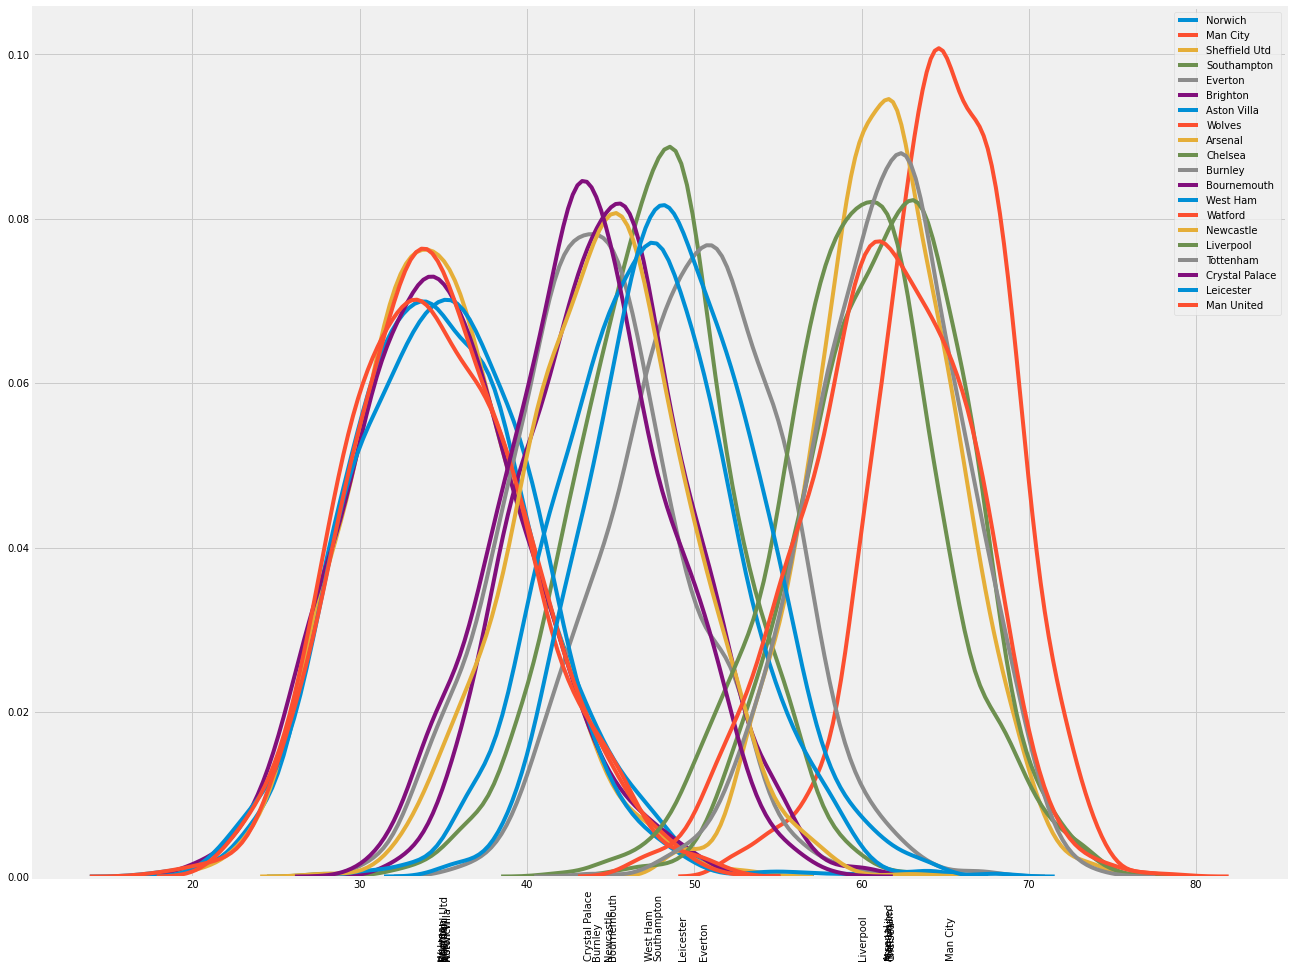

In [0]:
plt.figure(figsize=(20,16))
plt.tight_layout()
for team in team_state.keys():
  sns.kdeplot(tables.loc[tables.Team == team, 'Points'])
  plt.text(tables.loc[tables.Team == team, 'Points'].mean(), -0.01, team, rotation=90)
plt.legend(list(team_state.keys()))

plt.savefig(data_dir + 'probability-table.png', format='png',dpi=300, bbox_inches = "tight")

In [0]:
pickle.dump( tables, open( data_dir + "tables2.pickle", "wb" ) )

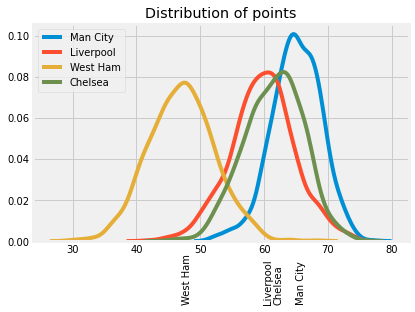

In [0]:
aa= ['Man City', 'Liverpool', 'West Ham', 'Chelsea']
for team in aa:
  sns.kdeplot(tables.loc[tables.Team == team, 'Points'])
  plt.text(tables.loc[tables.Team == team, 'Points'].mean(), -0.03, team, rotation=90)
plt.legend(aa)
plt.title('Distribution of points')
plt.savefig('probability-dist.png', format='png',dpi=300, bbox_inches = "tight")

In [0]:
results['WinProb'] = 0
results['DrawProb'] = 0
results['LossProb'] = 0
table = {team: 0 for team in results['Away Team'].unique()}
team_state = {team: np.random.choice(states) for team in results['Away Team'].unique()}
true_results = {team: 0 for team in results['Away Team'].unique()}

for i, match in results[~results.Result.isna()].iterrows():
  home_team = match['Home Team']
  away_team = match['Away Team']
  home_state = transitions.get(home_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[home_team]]
  away_state = transitions.get(away_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[away_team]]
  prob = win_prob(home_team, away_team, home_state, away_state)
  results.loc[i, ['WinProb', 'DrawProb', 'LossProb']] = prob
  team_state[home_team] = next_state(transitions.get(home_team, 0), team_state[home_team])
  team_state[away_team] = next_state(transitions.get(away_team, 0), team_state[away_team])
  if np.argmax(prob) == 0:
    table[home_team] += 3
  elif np.argmin(prob) == 2:
    table[away_team] += 3
  else:
    table[home_team] += 1
    table[away_team] += 1
  if int(match.Result[0]) > int(match.Result[-1]):
    true_results[home_team] += 3
  elif int(match.Result[0]) < int(match.Result[-1]):
    true_results[away_team] += 3
  else:
    true_results[away_team] += 1
    true_results[home_team] += 1
  
  


keys = list(team_state.keys())
tables = pd.DataFrame({'Team': keys, 'Points': [table[k] for k in keys], 'Run': [1 for _ in keys]}).sort_values(by='Points')

for j in range(2, 1001):
  table = {team: 0 for team in results['Away Team'].unique()}
  team_state = {team: np.random.choice(states) for team in results['Away Team'].unique()}

  for i, match in results[~results.Result.isna()].iterrows():
    home_team = match['Home Team']
    away_team = match['Away Team']
    home_state = transitions.get(home_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[home_team]]
    away_state = transitions.get(away_team, (0, {'D': 0, 'M':0, 'U':0}))[1][team_state[away_team]]
    prob = win_prob(home_team, away_team, home_state, away_state)
    results.loc[i, ['WinProb', 'DrawProb', 'LossProb']] = prob
    team_state[home_team] = next_state(transitions.get(home_team, 0), team_state[home_team])
    team_state[away_team] = next_state(transitions.get(away_team, 0), team_state[away_team])
    if np.argmax(prob) == 0:
      table[home_team] += 3
    elif np.argmin(prob) == 2:
      table[away_team] += 3
    else:
      table[home_team] += 1
      table[away_team] += 1
  tables = tables.append(pd.DataFrame({'Team': keys, 'Points': [table[k] for k in keys], 'Run': [j for _ in keys]}).sort_values(by='Points'))


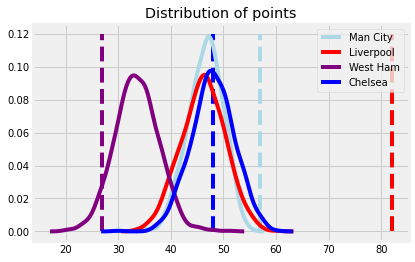

In [0]:
colors = ['lightblue', 'red', 'Purple', 'blue']
aa= ['Man City', 'Liverpool', 'West Ham', 'Chelsea']
for team, c in zip(aa,colors):
  sns.kdeplot(tables.loc[tables.Team == team, 'Points'], color=c)
  plt.vlines(true_results[team], ymin=0, ymax=0.12, colors=c, linestyles='dashed')
plt.legend(aa)
plt.title('Distribution of points')
plt.savefig('probability-dist2.png', format='png',dpi=300, bbox_inches = "tight")

In [0]:

summary = tables.groupby('Team', as_index=False)['Points'].mean()
true_results

{'Arsenal': 40,
 'Aston Villa': 25,
 'Bournemouth': 27,
 'Brighton': 29,
 'Burnley': 39,
 'Chelsea': 48,
 'Crystal Palace': 39,
 'Everton': 37,
 'Leicester': 53,
 'Liverpool': 82,
 'Man City': 57,
 'Man United': 45,
 'Newcastle': 35,
 'Norwich': 21,
 'Sheffield Utd': 43,
 'Southampton': 34,
 'Tottenham': 41,
 'Watford': 27,
 'West Ham': 27,
 'Wolves': 43}

In [0]:
summary = summary.sort_values(by='Points', ascending=False)
pos= 1
summary['Position'] = 0
summary['True Position'] = 0
for i, row in summary.iterrows():
  summary.loc[i, 'Position'] = pos
  pos +=1

pos -=1
for v,k in sorted((value, key) for (key,value) in true_results.items()):
  summary.loc[summary.Team ==k, 'True Position'] = pos
  pos -= 1


In [0]:
np.sum(np.abs(summary['Position'] - summary['True Position']))/20

4.3